# Energinet Current Electicity Generation

Scrapes electricity generation and usage data data from [https://energinet.dk/](https://energinet.dk/)

Load modules, selenium is used for rendering and requires a WebDriver.
Download [http://chromedriver.chromium.org/](chromedriver) or [https://github.com/mozilla/geckodriver/releases](geckodriver)

In [8]:
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from time import sleep
import datetime
from selenium.webdriver.chrome.options import Options
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
sea.set_palette(sea.cubehelix_palette(8, start=.5, rot=-.75))

Load web page and use Beautiful soup to parse. Store vales in pandas dataframe.

In [9]:
power = []
url = 'https://energinet.dk/'
tags = ["Centrale kraftværker", "Decentrale kraftværker", "Vindmøller", \
        "Solceller", "Nettoudveksling import", "Elforbrug", "CO2-udledning"]
driver = webdriver.Chrome(options=options, \
        executable_path="C:\\Users\\rpe\\AppData\\Local\\Chromedriver\\chromedriver.exe")
driver.get(url)
sleep(4)
data = driver.page_source
soup = bs(data, 'html.parser')
driver.close()

for tag in tags:
    item = soup.find(text=tag)
    b_tag = item.parent
    next_td_tag = b_tag.findNext('span')
    value = next_td_tag.contents[0]
    power.append([tag, int(value.split(" ")[0].replace(".", "")), 
                  value.split(" ")[1], datetime.datetime.now().strftime("%Y-%m-%d %H:%M")])

df = pd.DataFrame.from_records(power, columns=['Source', 'Amount', 'Units', 'Timestamp'])
df["Amount"] = pd.to_numeric(df["Amount"])
df = df.set_index("Source", drop = False)

Print dataframe

In [10]:
display(HTML(df.to_html()))
print("Number of lines: {}".format(df.shape[0]))

,Source,Amount,Units,Timestamp
Source,,,,
Centrale kraftværker,Centrale kraftværker,1373,MW,2019-02-27 08:15
Decentrale kraftværker,Decentrale kraftværker,682,MW,2019-02-27 08:15
Vindmøller,Vindmøller,1653,MW,2019-02-27 08:15
Solceller,Solceller,72,MW,2019-02-27 08:15
Nettoudveksling import,Nettoudveksling import,972,MW,2019-02-27 08:15
Elforbrug,Elforbrug,4751,MW,2019-02-27 08:15
CO2-udledning,CO2-udledning,163,g/kWh,2019-02-27 08:15


Number of lines: 7


Bar chart of energy sources

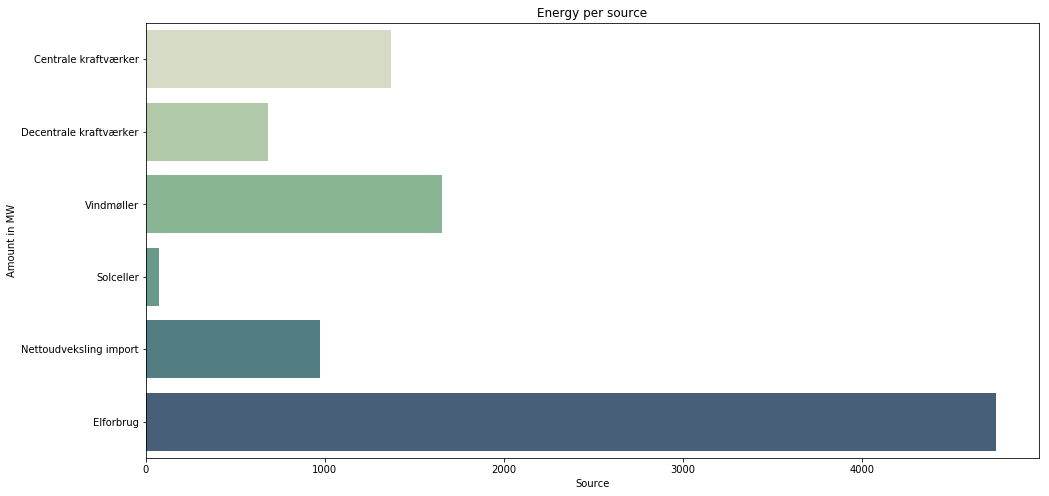

In [11]:
plt.rcParams["figure.figsize"] =(16,8)
ax = sns.barplot(y="Source", x="Amount", data=df[~df["Source"].isin(['CO2-udledning'])])
ax.set_ylabel('Amount in MW')
ax.set_xlabel('Source')
ax.set_title("Energy per source") 
plt.show()

Pie chart of Energy Production

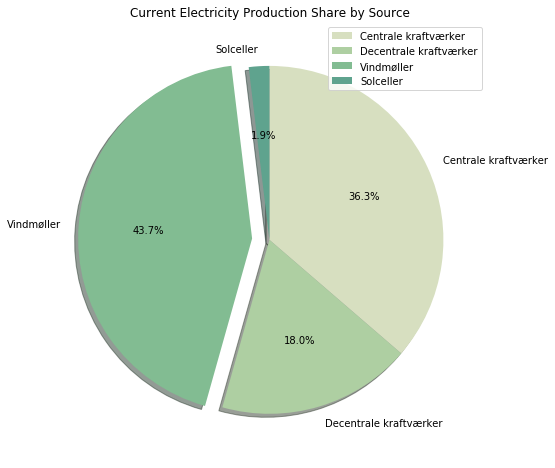

In [12]:
filter_rows = ['Nettoudveksling import','Elforbrug','CO2-udledning']
df_filtered = df.filter(items=['Source', 'Amount'])
df_filtered =df_filtered[~df_filtered["Source"].isin(filter_rows)]

labels = df_filtered["Source"]
values = df_filtered["Amount"]
explode = [0, 0, 0.1, 0]
plt.pie(values,explode=explode, labels=labels,counterclock=False, shadow=True, autopct='%1.1f%%', startangle=90)
plt.title('Current Electricity Production Share by Source')
plt.legend(labels,loc=1)
plt.show()

Summary of wind and solar share of enegy consumption

In [13]:
df1 = df.set_index("Source", drop = False)
usage = df1.loc["Elforbrug","Amount"]
print("Current electricity demand in Denmark is {} MW".format(usage))
print("Windpower currently produces {} MW or {:.2%} of demand".format(df1.loc["Vindmøller","Amount"],df1.loc["Vindmøller","Amount"]/usage))
print("Solarcells currently produce {} MW or {:.2%} of demand".format(df1.loc["Solceller","Amount"],df1.loc["Solceller","Amount"]/usage))                                   

Current electricity demand in Denmark is 4751 MW
Windpower currently produces 1653 MW or 34.79% of demand
Solarcells currently produce 72 MW or 1.52% of demand


Save data to csv, append to file it it already exists

In [14]:
file_name = "energinet.csv"
if os.path.exists(file_name):
    with open(file_name, 'a', encoding='utf-8') as f:
        df.to_csv(f, header=False, sep=";", index=False)
else:
    df.to_csv(path_or_buf=file_name, header=True, sep=";", index=False)

df.to_csv(sep=";")

'Source;Source;Amount;Units;Timestamp\nCentrale kraftværker;Centrale kraftværker;1373;MW;2019-02-27 08:15\nDecentrale kraftværker;Decentrale kraftværker;682;MW;2019-02-27 08:15\nVindmøller;Vindmøller;1653;MW;2019-02-27 08:15\nSolceller;Solceller;72;MW;2019-02-27 08:15\nNettoudveksling import;Nettoudveksling import;972;MW;2019-02-27 08:15\nElforbrug;Elforbrug;4751;MW;2019-02-27 08:15\nCO2-udledning;CO2-udledning;163;g/kWh;2019-02-27 08:15\n'